# Import librerie e API

A causa della nuova versione di tensorflow (2.16) si possono creare conflitti tra alibi, tensorflow e soprattutto keras, di cui è stata rilasciata la versione 3.0.
**Alla fine dell'import verrò chiesto di riavviare l'ambiente, fatelo e poi rieseguite questa cella per sicurezza**

In [ ]:
! pip install --upgrade tensorflow==2.15
! pip install split-folders
! pip install alibi[tensorflow]
from IPython.display import clear_output
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageFile
import random as rand
import os
import time
import tensorflow as tf
import splitfolders
from matplotlib import colormaps
from alibi.explainers import IntegratedGradients
from alibi.utils import visualize_image_attr
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
clear_output()

In [ ]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':"1dOIBPgvjVRkBX_8wkkUNHFxuHmT2vEOg"})   # replace the id with id of file you want to access
downloaded.GetContentFile('dataset.zip')
!unzip dataset
clear_output()

In [ ]:
#@title Barra di completamento estrazione features
import time
from IPython.display import HTML, display
#Function for progress bar.
def progress(value, max=100):
    return HTML("""<progress value='{value}' max='{max}', style='width: 100%'>
            {value}
        </progress>""".format(value=value, max=max))
print('Done! Press the Refresh button if files are not visible.')

Done! Press the Refresh button if files are not visible.


# Dataset

In [ ]:
test_dir = '/content/dataset_GB/Test'
print('Test/live count:', len(os.listdir(test_dir+'/Live')))
print('Test/Fake/Gelatine count:', len(os.listdir(test_dir+'/Fake/Gelatine')))
print('Test/Fake/WoodGlue count:', len(os.listdir(test_dir+'/Fake/WoodGlue')), '\n')

train_dir = '/content/dataset_GB/Train'
print('Train/live count:', len(os.listdir(train_dir+'/Live')))
print('Train/Fake/Gelatine count:', len(os.listdir(train_dir+'/Fake/Gelatine')))
print('Train/Fake/Latex count:', len(os.listdir(train_dir+'/Fake/Latex')))

Test/live count: 40
Test/Fake/Gelatine count: 20
Test/Fake/WoodGlue count: 20 

Train/live count: 100
Train/Fake/Gelatine count: 100
Train/Fake/Latex count: 100


Osservazioni sul dataset:
  * Basso numero di samples, sia in train che in test, sono perciò necessarie tecniche di data augmentation
  * Diversità tra i materiali potrebbero rendere più difficile l'identificazione di presentation attacks
  * Presenza di campioni fake (o live) senza il corrispettivo campione live (o fake)
  

Descrizione dataset:
Il dataset è costituito da 380 immagini di impronte digitali 500x500 in formato png; risulta etichettato e già suddiviso in Train e Test dataset:
 * Train dataset formato da 300 impronte di cui 100 vere, 100 false in gelatina e 100 false in latex.
 * Test dataset formato da 80 impronte di cui 40 vere, 20 in gelatina e 20 in WoodGlue.
Lo split è 74,4% Train, 26,6% Test.

Le impronte sono catalogate secondo lo schema "individuo_dito_rilevazione" (ad esempio 011_1_0 significa che è la prima rilevazione del secondo dito dell'individuo numero 011).

Nel training set live sono presenti tutte le impronte degli individui che figurano, ma non tutti gli individui del dataset. Le impronte fake presenti sono imitazioni delle impronte vere date in addestramento.

Nel dataset di testing sono presenti rilevazioni diverse di dita già rilevate in addestramento e rilevazioni di utenti non visti durante l'allenamento (ad es. l'utente 021), sia per le impronte live che per le impronte fake.

Essendo lo scopo di questa rete determinare o meno se un impronta sia live o spoof, il train dataset risulta sbilanciato, con una carenza di impronte vere: 33% vere, 66% false (gelatina + latex).


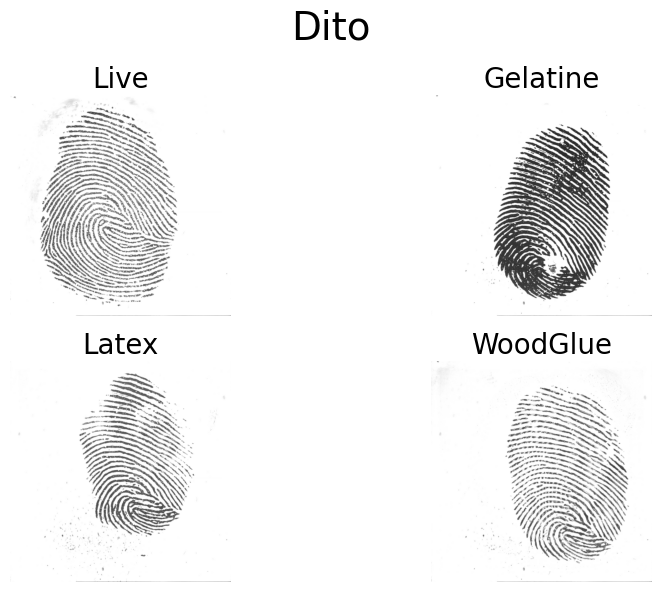

In [ ]:
images = [Image.open('/content/dataset_GB/Train/Live/002_0_0.png').convert('RGB')]
images.append(Image.open('/content/dataset_GB/Train/Fake/Gelatine/002_0_0.png').convert('RGB'))
images.append(Image.open('/content/dataset_GB/Train/Fake/Latex/002_0_0.png').convert('RGB'))
images.append(Image.open('/content/dataset_GB/Test/Fake/WoodGlue/002_0_4.png').convert('RGB'))

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 6), sharex=True, sharey=True)
axes[0,0].set_title('Live', fontsize=20)
axes[0,0].axis('off')
axes[0,0].imshow(images[0], cmap=plt.cm.gray)

axes[0,1].set_title('Gelatine', fontsize=20)
axes[0,1].axis('off')
axes[0,1].imshow(images[1], cmap=plt.cm.gray)

axes[1,0].set_title('Latex', fontsize=20)
axes[1,0].axis('off')
axes[1,0].imshow(images[2], cmap=plt.cm.gray)

axes[1,1].set_title('WoodGlue', fontsize=20)
axes[1,1].axis('off')
axes[1,1].imshow(images[3], cmap=plt.cm.gray)

plt.suptitle('Dito', fontsize=28)
fig.tight_layout()
plt.show()

Come abbiamo già detto in precedenza, lo scopo della nostra rete è una classificazione binaria: decidere se l'impronta presentata sia vera(live) o falsa(spoof), motivo per cui uniremo le cartelle delle impronte fake in un unica cartella.

Le immagini nelle cartelle rappresentanti le impronte Fake hanno gli stessi nomi.

per questo motivo le loro copie avranno una parte in più nel nome che indicherà se le impronte sono realizzate mediante la tecnica Gelatine (codice 0), la tecnica Latex (codice 1) o la tecnica WoodGlue (codice 2) (?)

Ad esempio l'immagine *008_7_3_**0**.jpg*  rappresenta la quarta rilevazione,dell'ottavo dito, dell'utente 008, attraverso la tecnica **Gelatine**

Per ottenere lo split del dataset richiesto, cioè 70% train, 10% validazione e 20 % test, riuniremo i due split del dataset per poi risuddividerli con la funzione splitfolders

In [ ]:
#@title Creazione Dataset
##Immagini live

ImageFile.LOAD_TRUNCATED_IMAGES = True
# Definisci il percorso della cartella sorgente e della cartella di destinazione
source_folders = ['/content/dataset_GB/Train/Live', '/content/dataset_GB/Test/Live']
destination_folder = '/content/DatasetCNN/Live'

# Verifica se la cartella di destinazione esiste, altrimenti creala
if not os.path.exists(destination_folder):
    os.makedirs(destination_folder, mode = 777)

for i in range(len(source_folders)):
  # Elenca tutti i file nella cartella sorgente
  for filename in os.listdir(source_folders[i]):
      # Verifica se il file ha estensione .png
      if filename.endswith('.png'):
          # Crea il percorso completo per il file sorgente
          source_path = os.path.join(source_folders[i], filename)

          # Apri l'immagine PNG
          with Image.open(source_path) as img:

              # Crea il nome del file per l'immagine PNG
              new_filename = f"{filename.split('.')[0]}.png"
              destination_path = os.path.join(destination_folder, new_filename)

              # Salva l'immagine in formato JPEG
              img.save(destination_path,)

print('\nCopia immagini live completata.')

## immagini fake
# Definisci il percorso della cartella sorgente e della cartella di destinazione
source_folders = ['/content/dataset_GB/Train/Fake','/content/dataset_GB/Test/Fake']
destination_folder = '/content/DatasetCNN/Fake'

# Verifica se la cartella di destinazione esiste, altrimenti creala
if not os.path.exists(destination_folder):
      os.makedirs(destination_folder, mode = 777)

# Elenca tutti i file nella cartella sorgente
for i in range(len(source_folders)):
  for type_folder in os.listdir(source_folders[i]):
    for filename in os.listdir(os.path.join(source_folders[i], type_folder)):

      # Verifica se il file ha estensione .png
      if filename.endswith('.png'):
        # Crea il percorso completo per il file sorgente
        source_path = os.path.join(source_folders[i], type_folder, filename)

        # Apri l'immagine PNG
        with Image.open(source_path) as img:

          # Crea il nome del file per l'immagine JPEG
          if (type_folder == 'Gelatine'):
            new_filename = f"{filename.split('.')[0]}_0.png"
          elif(type_folder == 'Latex'):
            new_filename = f"{filename.split('.')[0]}_1.png"
          else:   #caso WoodGlue
            new_filename = f"{filename.split('.')[0]}_2.png"
          destination_path = os.path.join(destination_folder, new_filename)

          img.save(destination_path)

print('Copia immagini false completata.')


Copia immagini live completata.
Copia immagini false completata.


Separazione dataset in training test e validation

In [ ]:
# Divisione del dataset originale in train/validation/test split seconodo i valori 70%/10%/20%
# La cartella del dataset deve trovarsi nello stesso percorso del notebook e deve essere unzippata
splitfolders.ratio(input="/content/DatasetCNN/",
                   output="dataset_split",
                   seed=147, # Seed di default, aggiunto per replicabilità
                   ratio=(.7,.1,.2), # Train/Val/Test split ratio
                   group_prefix=None,
                   move=False)

batch_size = 32 # Di default viene utilizzata 32
img_size = 500 # Poichè le immagini sono quadrate, dichiariamo una sola variabile per altezza/larghezza
print("\n")
# Dataset split
train_ds = tf.keras.utils.image_dataset_from_directory("dataset_split/train",
                                                       image_size=(img_size, img_size),# Dimensione delle immagini
                                                       seed = 147,
                                                       batch_size=batch_size, # Dimensione dei batch
                                                       label_mode='int', # Tipo di label assegnata
                                                       labels='inferred')# Modo di assegnazione delle label, per inferenza nel nostro caso ossia NomeCartella = Label]


test_ds = tf.keras.utils.image_dataset_from_directory("dataset_split/test",
                                                       image_size=(img_size, img_size), # Dimensione delle immagini
                                                       seed = 147,
                                                       batch_size=batch_size, # Dimensione dei batch
                                                       label_mode='int', # Tipo di label assegnata
                                                       labels='inferred')# Modo di assegnazione delle label, per inferenza nel nostro caso ossia NomeCartella = Label]


val_ds = tf.keras.utils.image_dataset_from_directory("dataset_split/val",
                                                     image_size=(img_size, img_size),
                                                     seed = 147,
                                                     batch_size=batch_size,
                                                     label_mode='int',
                                                     labels='inferred')

Copying files: 380 files [00:00, 4178.12 files/s]



Found 266 files belonging to 2 classes.
Found 76 files belonging to 2 classes.


Found 38 files belonging to 2 classes.


Conteggio delle immagini per classe, per ogni split del dataset

In [ ]:
train_dir = '/content/dataset_split/train'
print('Train/live count:', len(os.listdir(train_dir+'/Live')))
print('Train/Fake count:', len(os.listdir(train_dir+'/Fake')), '\n')

test_dir = '/content/dataset_split/test'
print('Test/live count:', len(os.listdir(test_dir+'/Live')))
print('Test/Fake count:', len(os.listdir(test_dir+'/Fake')), '\n')

val_dir = '/content/dataset_split/val'
print('Validation/live count:', len(os.listdir(val_dir+'/Live')))
print('Validation/Fake count:', len(os.listdir(val_dir+'/Fake')), '\n')

Train/live count: 98
Train/Fake count: 168 

Test/live count: 28
Test/Fake count: 48 

Validation/live count: 14
Validation/Fake count: 24 



# Metodo LBP

Il metodo LBP è ampiamente utilizzato nella classificazione di biometrie, specialmente nelle impronte digitali. Si basa sulle minuzie, che sono identificate tramitela costruzione di matrici dei valori dei pixel intorno ad un punto. I valori delle matrici vengono trasformati in 1 o 0 in base al threshold scelto, per essere poi concatenati e utilizzati per costruire l'istogramma rappresentativo dell'immagine, in cui ogni bucket corrisponde ad una feature
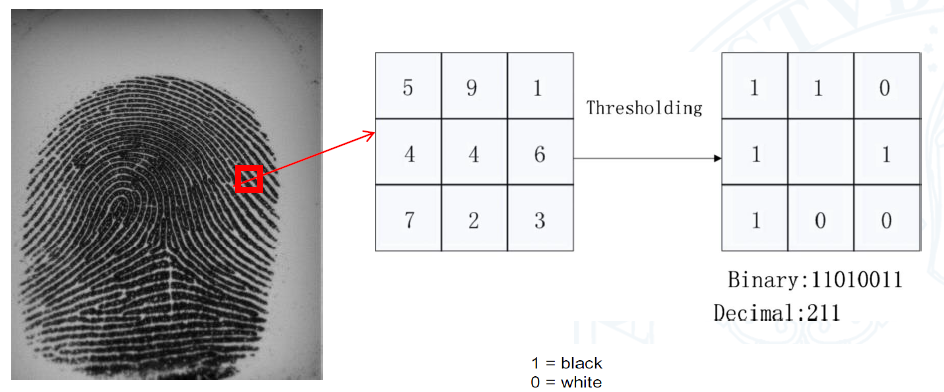

In [ ]:
def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):

    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val

def lbp(img):
  height, width = img.shape
  img_lbp = np.zeros((height, width,3), np.uint8)

  for i in range(0, height):
      for j in range(0, width):
            img_lbp[i, j] = lbp_calculated_pixel(img, i, j)
  hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
  hist_lbp = hist_lbp.astype("float")
  hist_lbp /= (hist_lbp.sum() + 1e-7)

  return hist_lbp.squeeze()

Mostriamo le differenze tra le immagini originali e le immagini ottenute con il metodo LBP

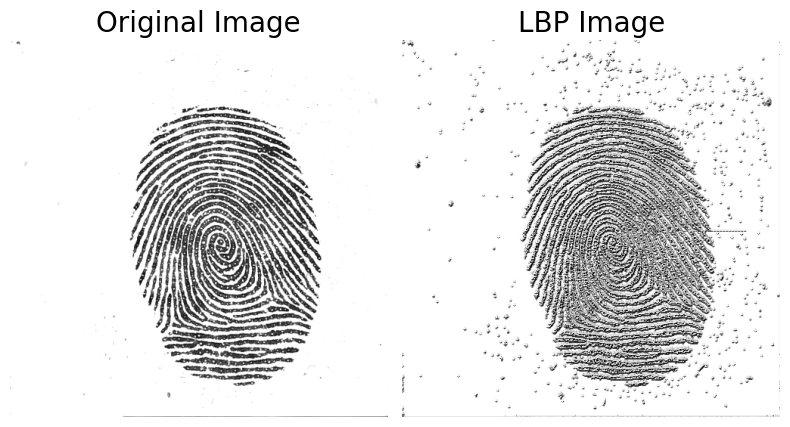

In [ ]:
image_file = '/content/dataset_split/test/Live/002_3_4.png'
img_bgr = cv2.imread(image_file)
height, width, channel = img_bgr.shape
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY) #grayscale conversion

img_lbp = np.zeros((height, width,3), np.uint8)
for i in range(0, height):
    for j in range(0, width):
          img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
hist_lbp = np.transpose(cv2.calcHist([img_lbp], [0], None, [256], [0, 256]))

#show images
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
plt.subplots_adjust(0.15)
axes[0].imshow(img_gray, cmap="gray")
axes[0].axis('off')
axes[0].set_title('Original Image', fontsize=20)
axes[1].imshow(img_lbp,cmap="gray")
axes[1].axis('off')
axes[1].set_title('LBP Image', fontsize=20)
fig.tight_layout()
plt.show()

In [ ]:
#@title Ottenere la lista dei file da una directory
def getListOfFiles(dirName):
    # creare una lista dei file e delle cartelle
    # nomi nella cartella data
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Itera su tutte le entrate
    for entry in listOfFile:
        # Crea path completo
        fullPath = os.path.join(dirName, entry)
        # Se l'entrata è una cartella prendi tutti i file dalla cartella
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles

In [ ]:
original_image_train = [] #array immagini di train
data_train = []           #array dati di train
labels_train = []         #array etichette di train

original_image_test = []  #array immagini di test
data_test = []            #array dati di test
labels_test = []          #array etichette di test

original_image_val = []   #array immagini di validation
data_val = []             #array dati di validation
labels_val = []           #array etichette di validation

path_train = "/content/dataset_split/train/"
path_test = "/content/dataset_split/test/"
path_val = "/content/dataset_split/val/"

train_images = getListOfFiles(path_train)
test_images = getListOfFiles(path_test)
val_images = getListOfFiles(path_val)

In [ ]:
#@title Estrazione LBP feature per ogni immagine del dataset

# T R A I N
print('Extracting LBP Code for train set (~9 minutes)...')
t = time.time()

out = display(progress(0, len(train_images)), display_id=True)
kk=0

for i in range(0,len(train_images)):
    x = train_images[i]
    gray = cv2.imread(x,0)
    hist = lbp(gray)

    original_image_train.append((gray, x))
    data_train.append(hist)
    if "Live" in x:
        labels_train.append(1)
    elif "Fake" in x:
        labels_train.append(0)
    kk=kk+1
    out.update(progress(kk, len(train_images)))

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed,'\n')


# T E S T
print('Extracting LBP Code for test set (~3 minutes)...')
t = time.time()

out = display(progress(0, len(test_images)), display_id=True)
kk=0

for i in range(0,len(test_images)):

    x = test_images[i]
    gray = cv2.imread(test_images[i],0)
    hist = lbp(gray)

    original_image_test.append((gray, x))
    data_test.append(hist)
    if "Live" in x:
        labels_test.append(1)
    elif "Fake" in x:
        labels_test.append(0)

    kk=kk+1
    out.update(progress(kk, len(test_images)))

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed)


# V A L I D A T I O N
print('Extracting LBP Code for test set (~3 minutes)...')
t = time.time()

out = display(progress(0, len(val_images)), display_id=True)
kk=0

for i in range(0,len(val_images)):

    x = val_images[i]
    gray = cv2.imread(val_images[i],0)
    hist = lbp(gray)

    original_image_val.append((gray, x))
    data_val.append(hist)
    if "Live" in x:
        labels_val.append(1)
    elif "Fake" in x:
        labels_val.append(0)

    kk=kk+1
    out.update(progress(kk, len(val_images)))

elapsed = 'Process completed! Elapsed time: %.2f s' %(time.time() - t)
print(elapsed)

Extracting LBP Code for train set (~9 minutes)...


Process completed! Elapsed time: 391.58 s 

Extracting LBP Code for test set (~3 minutes)...


Process completed! Elapsed time: 111.27 s
Extracting LBP Code for test set (~3 minutes)...


Process completed! Elapsed time: 56.44 s


Dato il tempo di estrazione features, salviamo le feature estratte in locale, per poterle poi ricaricare e risparmiare tempo.

In [ ]:
#@title salvataggio features LBP in locale
np.save('LBP_train_data.npy', np.array(data_train))
np.save('LBP_train_labels.npy', np.array(labels_train))

np.save('LBP_test_data.npy', np.array(data_test))
np.save('LBP_test_labels.npy', np.array(labels_test))

np.save('LBP_val_data.npy', np.array(data_val))
np.save('LBP_val_labels.npy', np.array(labels_val))

In [ ]:
#@title caricamento LBP features da directory locale
data_train = np.load('LBP_train_data.npy')
labels_train = np.load('LBP_train_labels.npy')

data_test = np.load('LBP_test_data.npy')
labels_test = np.load('LBP_test_labels.npy')

data_val = np.load('LBP_val_data.npy')
labels_val = np.load('LBP_val_labels.npy')

#Classificatore semplice

Utilizziamo un classificatore semplice (Decision Tree) di scikit-learn per vedere le performance. Scegliamo l'accuratezza come metrica principale visto che, data la carenza di immagini vere nel nostro dataset, ci interessa capire se il nostro classificatore riesce a differenziarle da quelle false, più rappresentate nel nostro dataset

In [ ]:
# TRAIN
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import cross_val_score

# instantiate the model
tree = DecisionTreeClassifier(max_depth = 5)
tree.fit(data_train, labels_train)

DecisionTreeClassifier(max_depth=5)

Effettuiamo una cross-validation con k = 5 per verificare la validità del modello

In [ ]:
# VAL
X = np.concatenate((data_train, data_val))
y = np.concatenate((labels_train, labels_val))

scores = cross_val_score(tree, X, y, cv=5)

print("%0.2f validation accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.81 validation accuracy with a standard deviation of 0.05


Infine facciamo il test, mostriamo la matrice di confusione e la curva ROC per il nostro Decision Tree

In [ ]:
# TEST
y_pred_tree = tree.predict(data_test)
acc_tree = accuracy_score(labels_test, y_pred_tree)*100
acc='Test decision tree Accuracy: %.2f %%' % acc_tree
print(acc)

Test decision tree Accuracy: 86.84 %


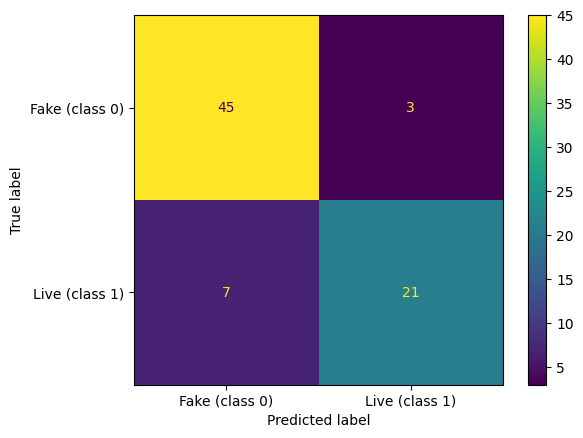

In [ ]:
cm = confusion_matrix(labels_test, y_pred_tree, labels=tree.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (class 0)', 'Live (class 1)'])
disp.plot()

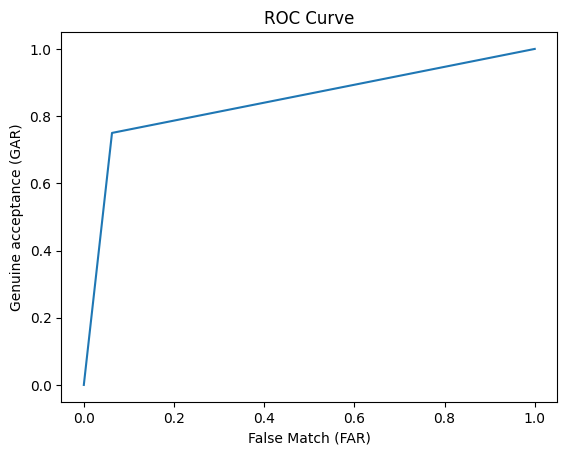

La Area Under Curve è 0.84375


In [ ]:
tpr, fpr, _ = roc_curve(labels_test, y_pred_tree)
plt.plot(tpr, fpr)
plt.title('ROC Curve')
plt.xlabel('False Match (FAR)')
plt.ylabel('Genuine acceptance (GAR)')
plt.show()
print(f'La Area Under Curve è {roc_auc_score(labels_test, y_pred_tree, labels = tree.classes_)}')

Ora vediamo quali immagini sono state classificate erroneamente dal classificatore semplice

In [ ]:
# vedere quale immagine è stata classificata in modo errato, con la rispettiva label vera e quella predetta
tree_prediction_errors = []
tree_prediction_guesses = []
print('Immagine \t True label \t Pred label')
for i in range(len(labels_test)):
  if labels_test[i] != y_pred_tree[i]:
    tree_prediction_errors.append((i, labels_test[i], y_pred_tree[i]))  # lista che contiene gli indici delle impronte classificate in modo errato, la classe vera di appartenenza e la classe predetta
    print(i, f'\t True label:{labels_test[i]}\t Pred label:{y_pred_tree[i]}')
  else:
    tree_prediction_guesses.append((i, labels_test[i], y_pred_tree[i]))


Immagine 	 True label 	 Pred label
2 	 True label:0	 Pred label:1
20 	 True label:0	 Pred label:1
29 	 True label:0	 Pred label:1
54 	 True label:1	 Pred label:0
57 	 True label:1	 Pred label:0
59 	 True label:1	 Pred label:0
62 	 True label:1	 Pred label:0
67 	 True label:1	 Pred label:0
68 	 True label:1	 Pred label:0
75 	 True label:1	 Pred label:0


Text(0.5, 1.0, '002_3_4.png, index: 57, True_class: 0, Pred_class: 1')

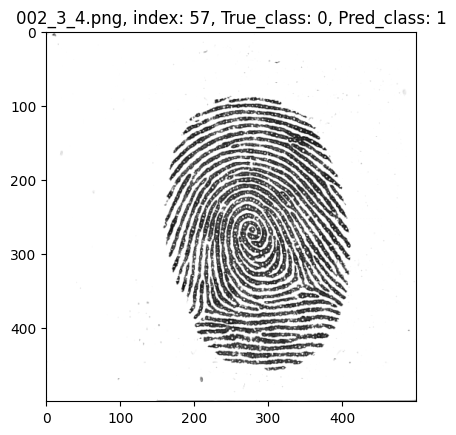

In [ ]:
# visualizziamo una impronta random classificata in modo errato dal decision tree classifier
index = tree_prediction_errors[rand.randint(0, len(tree_prediction_errors)-1)][0]
true_class = tree_prediction_errors[0][1]
pred_class = tree_prediction_errors[0][2]
plt.imshow(original_image_test[index][0], cmap=plt.cm.gray)
title = f'{original_image_test[index][1].split("/")[-1]}, index: {index}, True_class: {true_class}, Pred_class: {pred_class}'
plt.title(title)

#Classificatore multiplo
Proviamo ora con un calssificatore multiplo: un Random Forest con criterio di Gini e Hard Voting tra i 100 alberi che lo compongono. Avendo pochi campioni e due sole classi non è necessario che sia molto profondo.

In [ ]:
# TRAIN
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth=5)
forest.fit(data_train, labels_train)

RandomForestClassifier(max_depth=5)

Validiamo sempre con una Cross-Validation con numero di folds k = 5

In [ ]:
# VAL
X = np.concatenate((data_train, data_val))
y = np.concatenate((labels_train, labels_val))

scores = cross_val_score(forest, X, y, cv=5)

print("%0.2f validation accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.89 validation accuracy with a standard deviation of 0.03


E poi testiamo per ottenere l'accuratezza del nostro modello

In [ ]:
# TEST
y_pred_forest = forest.predict(data_test)
acc_forest = accuracy_score(labels_test, y_pred_forest)*100
acc='Test random forest Accuracy: %.2f %%' % acc_forest
print(acc)

Test random forest Accuracy: 97.37 %


Quindi mostriamo al matrice di confusione e la curva ROC

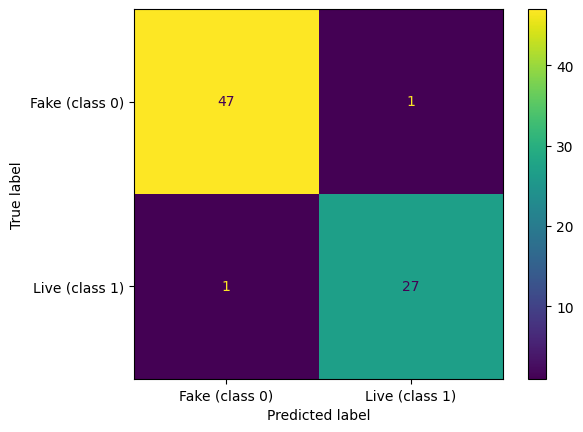

In [ ]:
cm = confusion_matrix(labels_test, y_pred_forest, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (class 0)', 'Live (class 1)'])
disp.plot()

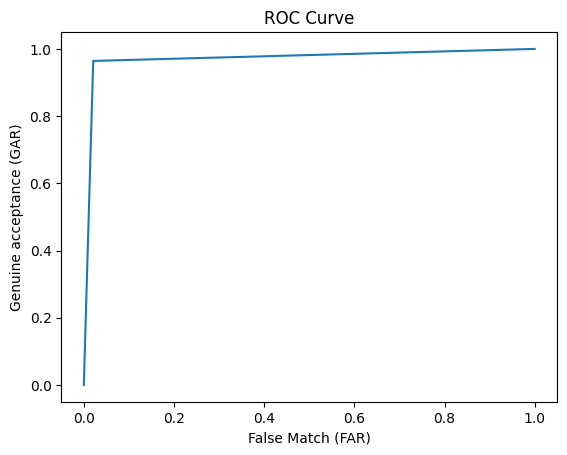

La Area Under Curve è 0.9717261904761906


In [ ]:
tpr, fpr, _ = roc_curve(labels_test, y_pred_forest)
plt.plot(tpr, fpr)
plt.title('ROC Curve')
plt.xlabel('False Match (FAR)')
plt.ylabel('Genuine acceptance (GAR)')
plt.show()
print(f'La Area Under Curve è {roc_auc_score(labels_test, y_pred_forest, labels = tree.classes_)}')

Possiamo vedere subito quanto il classificatore multiplo sia migliore del semplice Decision Tree, raggiungendo ottimi risultati con un tempo di esecuzione molto basso. L'altissimo valore di accuratezza raggiunto (oltre il 90% sul test), però indica che il nostro classicatore non avrà un'ottima capacità di generalizzazione e sarà meno utile nel caso in cui vengano presentate nuove impronte digitali mai viste dal modello.

Vediamo ora quali immagini sono state classificate erroneamente:

In [ ]:
# vedere quale immaggine è stata classificata in modo errato, con la rispettiva label vera e quella predetta
forest_prediction_errors = []
forest_prediction_guesses = []
print('index \t True label \t Pred label')
for i in range(len(labels_test)):
  if labels_test[i] != y_pred_forest[i]:
    forest_prediction_errors.append(((i, labels_test[i], y_pred_forest[i])))
    print(i, f'\t True label:{labels_test[i]}\t Pred label:{y_pred_forest[i]}')
  else:
    forest_prediction_guesses.append((i, labels_test[i], y_pred_forest[i]))


index 	 True label 	 Pred label
20 	 True label:0	 Pred label:1
59 	 True label:1	 Pred label:0


Text(0.5, 1.0, '003_9_0.png, index: 59, True_class: 0, Pred_class: 1')

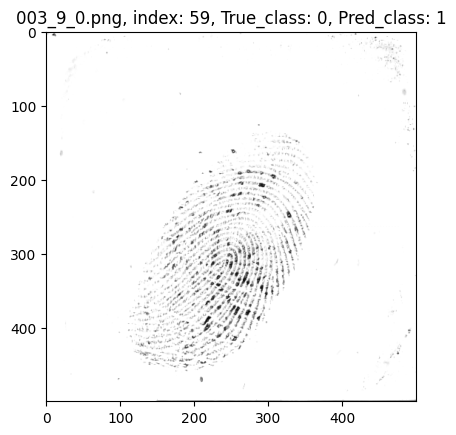

In [ ]:
# visualizziamo una impronta random classificata in modo errato dal random forest classifier
index = forest_prediction_errors[rand.randint(0, len(forest_prediction_errors)-1)][0]
true_class = forest_prediction_errors[0][1]
pred_class = forest_prediction_errors[0][2]
plt.imshow(original_image_test[index][0], cmap=plt.cm.gray)
title = f'{original_image_test[index][1].split("/")[-1]}, index: {index}, True_class: {true_class}, Pred_class: {pred_class}'
plt.title(title)

Vediamo ora gli errori (fino a 12) commessi dal classificatore semplice e dal classificatore multiplo

Gli errori sono soltanto  11


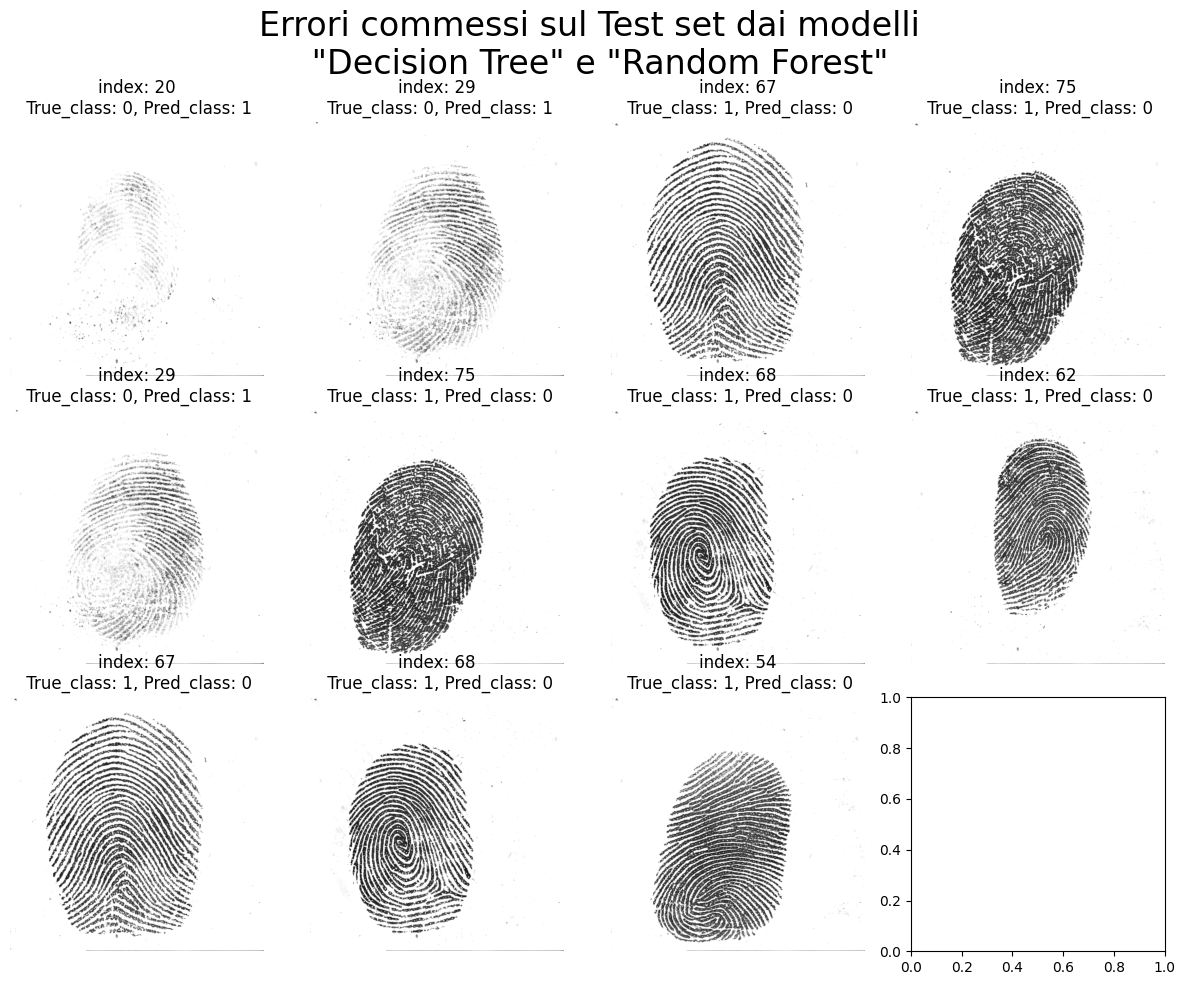

In [ ]:
# uniamo le due liste contenenti gli errori commessi dai due modelli, eliminando i duplicati
indici = list(set(forest_prediction_errors + tree_prediction_errors))[:12]

# creazione di una tabella 2 righe 6 colonne in cui mostrare 12 immagini in cui almeno un modello ha commesso un errore
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
for i in range(rows):
  for j in range(cols):
    k = ((i+1) * (j+1)) - 1 #indice per ciclare sulla lista 'indici'
    if k < len(indici):
      index = indici[k][0]  # indice dell'immagine nel test set
      true_class = indici[k][1] # classe vera dell'immagine
      pred_class = indici[k][2] # classe predetta dl modello
      img = original_image_test[index][0] # imagine di test

      axes[i, j].imshow(img, cmap=plt.cm.gray)  # mostrare l'immagine
      title = f'index: {index}\n True_class: {true_class}, Pred_class: {pred_class}'  # titolo del subplot con indice, etichetta vera ed etichetta predetta
      axes[i, j].set_title(title, fontsize=12)  # scrivo il titolo
      axes[i, j].axis('off')  # cancello gli assi
    else:
      print("Gli errori sono soltanto ", k)

plt.suptitle('Errori commessi sul Test set dai modelli \n "Decision Tree" e "Random Forest"', fontsize=24)
fig.tight_layout()
# plt.subplots_adjust(wspace=0.1)
plt.show()


# CNN


Andiamo ora a provare un approccio diverso alla risoluzione del problema: le reti neurali profonde.
Questo tipo di reti utilizza algoritmi di tipo "deep" che, tramite la funzione di loss e l'algoritmo di back-propagation, aggiornano i pesi dei neuroni che la compongono in base alla differenza tra output atteso e output della rete; riuscendo così ad imparare automaticamente a discriminare in base alle feature del dataset. Nel nostro caso utilizzeremo le  reti convolutive, che applicano dei filtri ad ogni porzione di immagini per calcolare una maschera che rappresenterà l'apprendimento delle feature.

Definiamo la struttura del modello, il preprocessing da applicare ai dati di train e le metriche di cui terremo conto. Visto il numero basso di campioni disponibili inseriamo un livello di data augmentation che consiste in: Flip orizzontale, rotazioni e zoom randomici. La rete è composta da 5 coppie di livelli convoluzionali 2D con numero di filtri crescenti e livelli MaxPooling, un sesto livello covoluzionale con 512 filtri e un livello di GlobalAveragePooling. Settiamo un dropout di 0.2, che disattiverà gli output del 20% dei neuroni, per poi inserire il nostro livello di classificazione. Stiamo considerando il nostro obbiettivo come una classificazione binaria, perciò utilizzeremo RMSProp con learning rate 0.0005 e momentum di 0.1(per cercare di non bloccarci in minimi locali della funzione) come ottimizzatore e binary crossentropy come loss function.

In [ ]:
#@title Struttura del modello

data_augmentation = tf.keras.Sequential([ # Data augmentation per aumentare il numero di casi in training
 tf.keras.layers.RandomFlip("horizontal"),
 tf.keras.layers.RandomRotation(0.1),
 tf.keras.layers.RandomZoom(0.2)]
)
metrics = [ # Metriche per la valutazione del modello
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'),
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]
Callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 20),
    tf.keras.callbacks.ModelCheckpoint("/content/model/Custom_model.keras",monitor = "val_accuracy",save_best_only = True),
]

inputs = tf.keras.Input(shape=(500,500,3)) # Strato di input

x = data_augmentation(inputs)
x = tf.keras.layers.Rescaling(1./255)(inputs) # Rescaling dell'input in valori tra 0.0 e 1.0


x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation='relu')(x)

x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)

outputs = tf.keras.layers.Dense(1,activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0005,momentum = 0.1 ), loss="binary_crossentropy", metrics=metrics)

model.summary() # Struttura della rete

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 500, 500, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 249, 249, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                      

In [ ]:
tf.config.list_physical_devices('GPU') #assicuriamoci che colab utilizzi la GPU per l'addestramento

[]

Addestriamo la rete. Questo richiederà un pò di tempo perchè la rete impari a discriminare correttamente le immagini

In [ ]:
history = model.fit(train_ds, validation_data = val_ds, epochs = 100, callbacks = Callbacks)

Epoch 1/100
9/9 [==============================] - 152s 17s/step - loss: 0.6709 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168.0000 - fn: 98.0000 - accuracy: 0.6316 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6632 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 24.0000 - val_fn: 14.0000 - val_accuracy: 0.6316 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/100
9/9 [==============================] - 149s 17s/step - loss: 0.6909 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168.0000 - fn: 98.0000 - accuracy: 0.6316 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6654 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 24.0000 - val_fn: 14.0000 - val_accuracy: 0.6316 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/100
9/9 [==============================] - 145s 16s/step - loss: 0.6721 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168.0000 - fn: 98.0000 - accuracy: 0.6316 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6623 - val_tp: 0.00

Mostriamo la loss in train e in validation, l'accuracy in train e in validation e la precisione e il recall.

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5), layout = "constrained")

loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
ax1.set_title("Loss")
ax1.plot(epochs, loss, "r--", label = "loss")
ax1.plot(epochs, val_loss, "b", label = "validated loss")
ax1.legend(loc = "upper left")

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
ax2.set_title("Accuracy")
ax2.plot(epochs, accuracy, "r--", label = "accuracy")
ax2.plot(epochs, val_accuracy, "b", label = "validated accuracy")
ax2.legend(loc = "upper left")

precision = history.history["val_precision"]
recall = history.history["val_recall"]
ax3.set_title("Validation precision and recall")
ax3.plot(epochs, precision, "r", label = "precision")
ax3.plot(epochs, recall, "g", label = "recall")
ax3.legend(loc = "upper left")

plt.show()

Possiamo salvare il modello in locale per evitare di dover riaddestrare la rete, caricandolo da drive

In [ ]:
from google.colab import files
files.download('/content/model/Custom_model.keras')

La fase iniziale mostra che per le prima 30 epoche, in base all'addestramento, non si mostra nessuna variazione. Questo è dovuto al fatto che in tutte quelle epoche la rete predice tutto come spoof, probabilmente per la grande differenza tra il numero di esempi con la classe Live. L'addestramento mostra un'instabilità accentuata che non sembra essere possibile rimuovere completamente. A causa di questa instabilità anche la riproducibilità degli esperimenti è compromessa, ma il modello migliore riesce ad ottenere ottimi risultati comunque. Per cercare di capire il perchè delle decisioni della rete possiamo utilizzare il metodo dei gradienti integrati di alibi.

Testing Custom Convolutional


Installiamo e importiamo Alibi e le altre librerie che utilizzeremo per valutare le decisioni del nostro modello con il metodo dei gradienti integrati. A causa dell'ultimo rilascio di tensorflow potrebbe mostrare un warning che richiede di riavviare la sessione, se succede premere annulla.

Carichiamo il modello migliore da Colab

In [ ]:
# Acquisizione del Modello migliore da Colab
model = tf.keras.models.load_model("/content/model/Custom_model.keras")

Oppure carichiamo il modello migliore salvato su Drive

In [ ]:
# Carica modello da Drive
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
model = tf.keras.models.load_model('/content/drive/MyDrive/Custom_model.keras')

Mostriamo ora come un immagine vera e una falsa vengono classificate dalla rete

In [ ]:
#@title Testing
img_path ="/content/dataset_split/test/Live/004_3_0.png" # immagine vera


def get_img_array(img_path, target_size):
  img = tf.keras.utils.load_img(img_path, target_size=target_size)
  array = tf.keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

img_array = get_img_array(img_path, target_size=(500, 500,3))

plt.axis("off")
plt.imshow(tf.keras.utils.load_img(img_path, target_size=(500, 500,3)))
plt.show()

preds = model.predict(img_array) #  Predizione
print("Immagine vera predetta come : ",'true' if preds > 0.5 else 'false',preds)

In [ ]:
img_path ="/content/dataset_split/test/Fake/004_3_0_0.png" #immagine fake

img_array = get_img_array(img_path, target_size=(500, 500,3))

plt.axis("off")
plt.imshow(tf.keras.utils.load_img(img_path, target_size=(500, 500,3)))
plt.show()

preds = model.predict(img_array) # Predizione
print("Immagine falsa predetta come : ",'true' if preds > 0.5 else 'false',preds)

Facciamo ora la predizione di tutte le etichette del dataset di test

In [ ]:
# Facciamo predire alla rete tutte le etichette del test set

predictions = model.predict(test_ds)
predictions = (predictions > 0.5).astype(int) # Le restituiamo come interi

Mostriamo la matrice di confusione e la curva ROC del modello

In [ ]:
cm = confusion_matrix(labels_test, predictions, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake (class 0)', 'Live (class 1)'])
disp.plot()

Possiamo vedere come la nostra CNN voti principalmente le immagini come false.

In [ ]:
tpr, fpr, _ = roc_curve(labels_test, predictions)
plt.plot(tpr, fpr)
plt.title('ROC Curve')
plt.xlabel('False Match (FAR)')
plt.ylabel('Genuine acceptance (GAR)')
plt.show()
print(f'La Area Under Curve è {roc_auc_score(labels_test, predictions, labels = tree.classes_)}')

Il modello è veramente poco efficace, con un AUC sotto lo 0,5 risulta peggiore di un lancio di moneta per decidere la classe e utilizzarla come strumento di rilevamento di attacco sarebbe dannoso per qualsiasi soggetto. I modelli di deep learning richiedono una grande quantità di dati di training per imparare in modo efficace, caratteristica che sicuramente si riscontra in questo caso.
Ora confrontiamo le label vere con quelle predette per vedere su quali immagini la predizione è stata errata

In [ ]:
CNN_prediction_errors = []
CNN_prediction_guesses = []
print('index \t True label \t Pred label')
for i in range(len(labels_test)):
  if labels_test[i] != predictions[i]:
    CNN_prediction_errors.append((i, labels_test[i], predictions[i]))  # lista che contiene gli indici delle impronte classificate in modo errato, la classe vera di appartenenza e la classe predetta
    print(i, f'\t True label:{labels_test[i]}\t Pred label:{predictions[i]}')
  else:
    CNN_prediction_guesses.append((i, labels_test[i], predictions[i]))


Proviamo ora a capire il perchè di queste predizioni errate, utilizzando il metodo dei gradienti integrati fornito da Alibi per capire quali parti dell'immagine portano il nostro modello a decidere l'etichetta

In [ ]:
#@title Explanation
n_steps = 50    # Numero di passi per l'interazione
method = "gausslegendre"    # Metodo di integrazione
internal_batch_size = 50    # dimensione del batch

# Inizializzazione dell'istanza "IntegratedGradients"
ig  = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

Per applicare il metodo di spiegazione (explanation) scelto alle immagini dobbiamo prima trasformare in numpy array le immagini.

In [ ]:
X_test = []
Y_test = []

# Itera attraverso il dataset di test per ottenere le immagini e le etichette
for image_batch, label_batch in test_ds:
    X_test.extend(image_batch.numpy())  # aggiunge il batch di immagini alla lista X_test
    Y_test.extend(label_batch.numpy())

# conversione da lista a array NumPy
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Utilizziamo la normalizzazione dei dati per ottenere tra 0 e 1
X_test = X_test.astype('float32')/255.0

Prendiamo le prime 3 immagini classificate erroneamente e applichiamo il metodo di spiegazione della rete

In [ ]:
# Selezione le 3 immagini come istanza
count = 3   # utilizziamo 3 immagini da considerare
n_img = 76  # numero di immagini nel set di test
instances = []  # lista per la memorizzazione delle istanze delle immagini
img_number = list()

for i in range(count):
  img_number.append(CNN_prediction_errors[i][0]) #salviamo l'indice della i-esima immagine classificata erroneamente
  instance = np.expand_dims(X_test[img_number[i]], axis=0)
  instances.append(instance)
  # Grazie a predictions otteniamo le predizioni per l'istanza

# Attraverso la funzione ig.explain ci permette di spiegare l'istanza
explanation = []
for i in range(count):
    # recuperiamo l'istanza e la predizione dalle liste create in precedenza
    instance = instances[i]
    prediction = predictions[i]
    explanation_i = ig.explain(instance,
                            baselines=None,
                            target=prediction)
    explanation.append(explanation_i)

In [ ]:
# Otteniamo le attribuzioni dell'oggetto explanation
attrs = []
for i in range(count):
    attrs_i = explanation[i].attributions[0]
    attrs.append(attrs_i)

Ora visualizziamo le immagini originali con la loro predizione, l'attribuzione che viene data ad ogni pixel delle immagini dalla rete e le due immagini sovrapposte per vedere quale area dell'immagine risulta più significativa per la classificazione.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=count, figsize=(14, 12))
amp = 0.1
cmap_bound = np.abs(attrs).max() # calcola il valore assoluto attraverso la funzione abs, estraendo poi il massimo
cmap_bound *= amp

cmap = colormaps.get_cmap('coolwarm')  # Potrebbe visualizzare un warning in quanto deprecata in Matplotlib 3.7

for i in range(count):
    # Visualizzazione dell'immagine originale
    ax[0, i].imshow(X_test[img_number[i]])
    ax[0, i].set_title(f'Immagine {img_number[i]} Label : {Y_test[img_number[i]]} Predizione : {predictions[img_number[i]]}')


    # Normalizzazione delle attribuzioni tra 0 e 1
    normalized_attrs = attrs[i] / cmap_bound
    normalized_attrs = np.clip(normalized_attrs, 0, 1)


    # Visualizzazione delle attribuzioni sovrapposte all'immagine originale
    img = ax[1, i].imshow(normalized_attrs.squeeze(), cmap=cmap, interpolation='bilinear')
    ax[1, i].set_title('Attribuzioni')

    # Visualizzazione delle attribuzioni sovrapposte all'immagine originale
    visualize_image_attr(attr=attrs[i].squeeze(), original_image=X_test[img_number[i]], method='blended_heat_map',
                        sign='all', show_colorbar=True, title='Sovrapposizione',
                        plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)


    # Aggiusta gli spazi per assicurarsi che il testo non venga tagliato
    plt.subplots_adjust(bottom=0.2)

    # Rimuovi gli assi
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
# Legenda del Grafico
# Aggiunta della legenda sulla destra
cax = fig.add_axes([.95, 0.2, 0.03, 0.6])  # Definizione delle dimensioni e della posizione
fig.colorbar(img, cax=cax)


plt.tight_layout()
plt.show()

Possiamo vedere graficamente perchè la rete custom sbaglia così tante volte: non considera le parti più significative delle impronte come tali. Nello specifico sembra dare più importanza ai "bordi" dell'impronta, in cui ci sono meno minuzie e quindi meno informazione. Con un numero maggiore di esempi probabilmente questa rete sarebbe molto più performante, soprattutto perchè distinguerebbe meglio l'area più distintiva per le impronte, cioè il vortice centrale detto core o whorl. Si può anche vedere come la qualità dell'impronta infici molto sulla classificazione

# Transfer Learning Model

Un approccio comune e molto efficace su piccoli insiemi di dati di immagini è l'uso di un modello pre-addestrato. Un modello pre-addestrato è un modello che è stato precedentemente addestrato su un set di dati di grandi dimensioni, in genere su un compito di classificazione di immagini su larga scala. Se questo set di dati originale è sufficientemente ampio e generale, la rappresentazione spaziale delle caratteristiche apprese dal modello pre-addestrato può effettivamente agire come un modello generico del mondo visivo, risolvendo il nostro problema del dataset limitato.
Abbiamo scelto come base la rete VGG19, addestrata su un enorme numero di immagini di vario tipo, dalle ottime capacità di generalizzazione.

Importeremo il modello senza i livelli di classificazione, che saranno addestrati sui nostri dati per specializzarli.

In [ ]:
#@title Struttura del modello
conv_base = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(500,500,3),
    classes=2,
    classifier_activation='sigmoid'
)
conv_base.summary()

Per ottenere i dati da passare al livello di classficazione nel formato corretto, creiamo una funzione per preprocessare i dati e per farli processare dai livelli della rete VGG19.

In [ ]:
def get_features_and_labels(dataset):
 all_features = []
 all_labels = []

 for images, labels in dataset:
  preprocessed_images = tf.keras.applications.vgg19.preprocess_input(images)
  features = conv_base.predict(preprocessed_images)
  all_features.append(features)
  all_labels.append(labels)

 return np.concatenate(all_features), np.concatenate(all_labels)

Applichiamo la funzione ai tre split del dataset (potrebbe richiedere qualche minuto)

In [ ]:
train_features, train_labels = get_features_and_labels(train_ds)
val_features, val_labels = get_features_and_labels(val_ds)
test_features, test_labels = get_features_and_labels(test_ds)

Definiamo i livelli di classificazione, le callbacks e le metriche necessarie

In [ ]:
inputs = tf.keras.Input(shape=(15, 15, 512))

x = tf.keras.layers.Flatten()(inputs)
x = tf.keras.layers.Dense(512)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

t_model = tf.keras.Model(inputs, outputs)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 20),
    tf.keras.callbacks.ModelCheckpoint("/content/model/Transfer_model.keras",monitor = "val_accuracy",save_best_only = True),
]

metrics = [ # Metriche per la valutazione del modello
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
]

Infine addestriamo solo i livelli di classificazione con i dati precedentemente preprocessati

In [ ]:
t_model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=metrics)

t_history = t_model.fit(train_features, train_labels, epochs=20, validation_data=(val_features, val_labels), callbacks=callbacks)

Ora mostriamo le statistiche del nostro modello di transfer learning

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize = (20,5), layout = "constrained")

loss = t_history.history["loss"]
val_loss = t_history.history["val_loss"]
epochs = range(1,len(loss)+1)
ax1.set_title("Vgg19 Loss")
ax1.plot(epochs, loss, "r--", label = "loss")
ax1.plot(epochs, val_loss, "b", label = "validated loss")
ax1.legend(loc = "upper left")

accuracy = t_history.history["accuracy"]
val_accuracy = t_history.history["val_accuracy"]
ax2.set_title("Vgg19 Accuracy")
ax2.plot(epochs, accuracy, "r--", label = "accuracy")
ax2.plot(epochs, val_accuracy, "b", label = "validated accuracy")
ax2.legend(loc = "upper left")

precision = t_history.history["precision"]
recall = t_history.history["recall"]
ax3.set_title("Vgg19 precision and recall")
ax3.plot(epochs, precision, "r", label = "precision")
ax3.plot(epochs, recall, "g", label = "recall")
ax3.legend(loc = "upper left")

plt.show()

Possiamo notare come questa rete sia in grado di classificare il dataset in modo molto migliore rispetto alla nostra rete convolutiva custom e che non si presenta la stessa quantità di picchi che distinguono il processo di apprendimento utilizzando solo il dataset di train per inferire i risultati. Un'approccio di questo tipo sembra essere, quindi, ottimale. I valori delle metriche indicano comunque una forte propensione all'overfitting, quindi questa rete avrà difficoltà a classificare dati mai visti. Vediamo le performance sul dataset di test.

Salviamo il modello addestrato per poterlo caricare in seguito

In [ ]:
files.download('/content/model/Custom_model.keras')

In [ ]:
#carica modello da drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#@title Testing
t_predictions = t_model.predict(test_features)
t_predictions = (t_predictions > 0.5).astype(int) # Le restituiamo come interi

Vediamo la matrice di confusione e la curva ROC

In [ ]:
cm = confusion_matrix(test_labels, t_predictions, labels = [0,1])
cmd = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Fake Class (0)','True Class(1)'])
cmd.plot()

In [ ]:
tpr, fpr, _ = roc_curve(labels_test, t_predictions)
plt.plot(tpr, fpr)
plt.title('ROC Curve')
plt.xlabel('False Match (FAR)')
plt.ylabel('Genuine acceptance (GAR)')
plt.show()
print(f'La Area Under Curve è {roc_auc_score(labels_test, t_predictions, labels = tree.classes_)}')

E ora vediamo su quali immagini ha sbagliato la classificazione

In [ ]:
Custom_pred = list()
for arr in t_predictions:
  Custom_pred.append(arr[0])
t_predictions = Custom_pred

In [ ]:
Transfer_prediction_errors = []
Transfer_prediction_guesses = []
print('index \t True label \t Pred label')
for i in range(len(test_labels)):
  if test_labels[i] != t_predictions[i]:
    Transfer_prediction_errors.append((i, test_labels[i], t_predictions[i]))  # lista che contiene gli indici delle impronte classificate in modo errato, la classe vera di appartenenza e la classe predetta
    print(i, f'\t True label:{test_labels[i]}\t Pred label:{t_predictions[i]}')
  else:
    Transfer_prediction_guesses.append((i, test_labels[i], t_predictions[i]))


Utilizziamo di nuovo il metdo dei gradinte integrati di Alibi per vedere come vengono attribuiti i valori ai pixel, cioè quali parti delle immagini discriminano maggiormente le impronte reali e le impronte spoof

In [ ]:
#@title Explanation
n_steps = 50    # Numero di passi per l'interazione
method = "gausslegendre"    # Metodo di integrazione
internal_batch_size = 50    # dimensione del batch

# Inizializzazione dell'istanza "IntegratedGradients"
ig  = IntegratedGradients(model,
                          n_steps=n_steps,
                          method=method,
                          internal_batch_size=internal_batch_size)

Per applicare il metodo di spiegazione (explanation) scelto alle immagini dobbiamo prima trasformare in numpy array le immagini.

In [ ]:
X_test = []
Y_test = []

# Itera attraverso il dataset di test per ottenere le immagini e le etichette
for image_batch, label_batch in test_ds:
    X_test.extend(image_batch.numpy())  # aggiunge il batch di immagini alla lista X_test
    Y_test.extend(label_batch.numpy())

# conversione da lista a array NumPy
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Utilizziamo la normalizzazione dei dati per ottenere tra 0 e 1
X_test = X_test.astype('float32')/255.0

Prendiamo le immagini classificate erroneamente e applichiamo il metodo di spiegazione della rete.

In [ ]:
# Selezione le immagini come istanza
count = 3 if len(Transfer_prediction_errors) > 3 else len(Transfer_prediction_errors)   # prendiamo al massimo 3 immagini da considerare
n_img = 76  # numero di immagini nel set di test
instances = []  # lista per la memorizzazione delle istanze delle immagini
img_number = list()

for i in range(count):
  img_number.append(CNN_prediction_errors[i][0]) #salviamo l'indice della i-esima immagine classificata erroneamente
  instance = np.expand_dims(X_test[img_number[i]], axis=0)
  instances.append(instance)
  # Grazie a predictions otteniamo le predizioni per l'istanza

# Attraverso la funzione ig.explain ci permette di spiegare l'istanza
explanation = []
for i in range(count):
    # recuperiamo l'istanza e la predizione dalle liste create in precedenza
    instance = instances[i]
    prediction = predictions[i]
    explanation_i = ig.explain(instance,
                            baselines=None,
                            target=prediction)
    explanation.append(explanation_i)

In [ ]:
# Otteniamo le attribuzioni dell'oggetto explanation
attrs = []
for i in range(count):
    attrs_i = explanation[i].attributions[0]
    attrs.append(attrs_i)

Ora visualizziamo le immagini originali con la loro predizione, l'attribuzione che viene data ad ogni pixel delle immagini dalla rete e le due immagini sovrapposte per vedere quale area dell'immagine risulta più significativa per la classificazione.

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=count, figsize=(14, 12))
amp = 0.1
cmap_bound = np.abs(attrs).max() # calcola il valore assoluto attraverso la funzione abs, estraendo poi il massimo
cmap_bound *= amp

cmap = colormaps.get_cmap('coolwarm')  # Potrebbe visualizzare un warning in quanto deprecata in Matplotlib 3.7

for i in range(count):
    # Visualizzazione dell'immagine originale
    ax[0, i].imshow(X_test[img_number[i]])
    ax[0, i].set_title(f'Immagine {img_number[i]} Label : {Y_test[img_number[i]]} Predizione : {t_predictions[img_number[i]]}')


    # Normalizzazione delle attribuzioni tra 0 e 1
    normalized_attrs = attrs[i] / cmap_bound
    normalized_attrs = np.clip(normalized_attrs, 0, 1)


    # Visualizzazione delle attribuzioni sovrapposte all'immagine originale
    img = ax[1, i].imshow(normalized_attrs.squeeze(), cmap=cmap, interpolation='bilinear')
    ax[1, i].set_title('Attribuzioni')

    # Visualizzazione delle attribuzioni sovrapposte all'immagine originale
    visualize_image_attr(attr=attrs[i].squeeze(), original_image=X_test[img_number[i]], method='blended_heat_map',
                        sign='all', show_colorbar=True, title='Sovrapposizione',
                        plt_fig_axis=(fig, ax[2, i]), use_pyplot=False)


    # Aggiusta gli spazi per assicurarsi che il testo non venga tagliato
    plt.subplots_adjust(bottom=0.2)

    # Rimuovi gli assi
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')
# Legenda del Grafico
# Aggiunta della legenda sulla destra
cax = fig.add_axes([.95, 0.2, 0.03, 0.6])  # Definizione delle dimensioni e della posizione
fig.colorbar(img, cax=cax)


plt.tight_layout()
plt.show()

# Confronto




In [ ]:
# uniamo le due liste contenenti gli errori commessi dai due modelli, eliminando i duplicati
indici = list(set(Transfer_prediction_errors + forest_prediction_errors + CNN_prediction_errors))[:12]

# creazione di una tabella 2 righe 6 colonne in cui mostrare 12 immagini in cui almeno un modello ha commesso un errore
rows = 3
cols = 4
fig, axes = plt.subplots(rows, cols, figsize=(12, 10))
for i in range(rows):
  for j in range(cols):
    k = ((i+1) * (j+1)) - 1 #indice per ciclare sulla lista 'indici'
    index = indici[k][0]  # indice dell'immagine nel test set
    true_class = indici[k][1] # classe vera dell'immagine
    pred_class = indici[k][2] # classe predetta dl modello
    img = original_image_test[index][0] # imagine di test

    axes[i, j].imshow(img, cmap=plt.cm.gray)  # mostrare l'immagine
    title = f'index: {index}\n True_class: {true_class}, Pred_class: {pred_class}'  # titolo del subplot con indice, etichetta vera ed etichetta predetta
    axes[i, j].set_title(title, fontsize=12)  # scrivo il titolo
    axes[i, j].axis('off')  # cancello gli assi

plt.suptitle('Errori commessi sul Test set dai modelli \n "Transfer Learning" e "Random Forest"', fontsize=24)
fig.tight_layout()
# plt.subplots_adjust(wspace=0.1)
plt.show()

# verifica delle identità
